Welcome to the EPISOL Colab Playground!



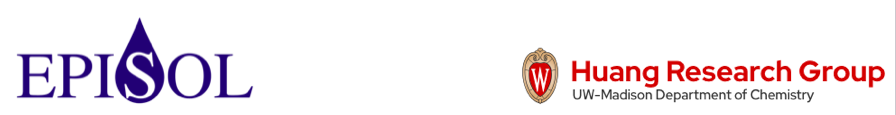

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through a high-throughput calculation on the solvation free energy of a test set of small molecules. We will compare our 3DRISM results to those of experimentally and computationally (FEP) determined free energies.   

* **goals**:
  * Generate the coordinate and topology files for our test set using RDKit and openFF
  * Perform high-throughput 3DRISM calculations to determine solvation free energy of 100 molecules in the test set
  * Be able to perform similar calculations on your own molecules
    * use the colab-notebook to download and run calculations on your own molecules

Please citate the following papers for Epipy and EPISOL:

A Python Tutorial for 3DRISM Solvation Calculations of Chemical and Biological Molecules", Swanson, P., Cao, S., Huang, X, https://chemrxiv.org/engage/chemrxiv/article-details/68a6903c728bf9025e6c91ed``

EPISOL: A Software Package with Expanded Functions to Perform 3D-RISM Calculations for the Solvation of Chemical and Biological Molecules“, Cao, S.; Kalin, M.L.; Huang, X., J. Comput. Chem., 44, 1536-1549, (2023)



In [ ]:
#@markdown install episol kernel
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
#%cd /content
########################### WRAPEPR

import matplotlib.pyplot as plt
!pip install episol


In [19]:
import numpy as np
import json
import matplotlib.pyplot as plt
from episol import epipy

#**Walk Through Calculation:**

* for this tutorial we will look at the solvation free energy of small molecules using FreeSolv Database
* lets download our files

In [27]:
%%capture
!wget https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/database.txt
!wget https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/gromacs.tar.gz
!wget https://raw.githubusercontent.com/MobleyLab/FreeSolv/refs/heads/master/smiles_to_cid.json
!tar -xzf gromacs.tar.gz

with open("smiles_to_cid.json",'r') as f:
  conversion = json.load(f)

* now we will make a list containing allof the SMILES strings and their corresponding energies

In [22]:
line_count = int()
experimental_values = []
calculated_values = []
smiles_list = []
names_list = []

with open('database.txt','r') as r:
  for line in r:
    line_count +=1
    if line_count > 3:
      tmp = line.split(';')
      try:
        names_list.append('_'.join(tmp[2].split()))
        smiles_list.append(tmp[1].strip())
        experimental_values.append(float(tmp[3].strip()))
        calculated_values.append(float(tmp[5].strip()))
      except Exception as exc:
        RuntimeWarning(exc)
smiles_list = np.array(smiles_list)
names_list = np.array(names_list)
experimental_values = np.array(experimental_values)
calculated_values = np.array(calculated_values)


In [41]:
to_use = conversion[smiles_list[0]]
test = epipy('gromacs/'+to_use+".gro",'gromacs/'+to_use+".top",gen_idc=True)
test.ndiis = 5
test.delvv = 0.5
test.r_c = 0.1 # cutoff at 0.9 nm instead of 1 nm (default)
test.err_tol = 1e-8
test.rism(resolution=0.5)
test.kernel(nt=2)

converted mobley_1017962.top to mobley_1017962.solute
generated idc-enabled solute file to: idc_mobley_1017962.solute
Failed to reach desired err_tol of 1e-08
Actual error: 4.08667e-06
Difference: -4.07667e-06
RISM finished at step 500


* our output energy is in units of kJ/mol
* we can specify the units if need be by feeding our desired string to the function

In [ ]:
test.free_energy('kcal/mol')

0.20729685904554024

* lets see the energy _per_ molecuule

In [ ]:
test.free_energy('kcal')

1.2483416851722435e+23

* now lets run the first N molecules in the test set

In [ ]:
number_of_molecules_to_use = 50

rng = np.random.default_rng()
ind_to_extract = rng.integers(len(smiles_list),size=number_of_molecules_to_use)

#smiles_and_names = dict(zip(names_list[ind_to_extract],smiles_list[ind_to_extract]))
smiles_and_names = dict(zip(names_list[:number_of_molecules_to_use],smiles_list[:number_of_molecules_to_use]))


In [ ]:
len(smiles_and_names)

50

Run

(because we are not using any packages, we are restricted by the gro inputs from the mobley set. they use an extremely large box size which necessitates a longer rism calculation. if you want things to go faster, see our 'non-plain' tutorials

In [ ]:
out_energies = []

for name in smiles_list[:20]:
  to_use = conversion[name]
  test = epipy('gromacs/'+to_use+".gro",'gromacs/'+to_use+".top",gen_idc=True)
  test.ndiis = 5
  test.delvv = 0.5
  test.r_c = 0.1 # cutoff at 0.9 nm instead of 1 nm (default)
  test.err_tol = 1e-8
  test.rism(resolution=0.5)
  test.kernel(nt=2)
  out_energies.append(test.free_energy('kcal/mol'))


converted mobley_1017962.top to mobley_1017962.solute
generated idc-enabled solute file to: idc_mobley_1017962.solute


* now, lets see our results

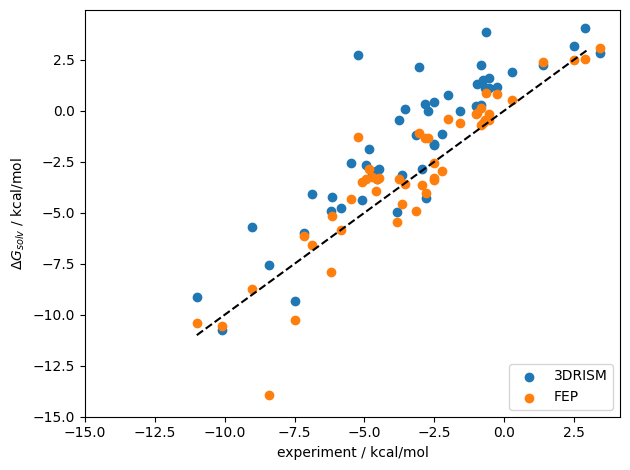

In [ ]:
fig,ax = plt.subplots()

#out_energies = np.copy(np.array(out_en))
dslice = len(out_energies)
ax.scatter(experimental_values[:dslice],out_energies,label='3DRISM')
ax.scatter(experimental_values[:dslice],calculated_values[:dslice],label='FEP')
#ax1.scatter(calculated_values[:dslice],out_energies)
#ax1.set_xlabel("experimental values")
ax.set_ylabel("$\\Delta G_{solv}$ / kcal/mol")
ax.set_xlabel("experiment / kcal/mol")
vv = np.arange(min(experimental_values[:dslice]),max(experimental_values[:dslice]))
ax.plot(vv,vv,'k--')
ax.set_ylim(-15,None)
ax.set_xlim(-15,None)
ax.legend(loc="lower right")
fig.tight_layout()